## Communication Evolution with Gradual Chunk

here we extends the convention-formation framework from Notebook 3 to study cultural evolution of communication systems

We fixed the meaning: tower program never changes across generations

We expect the lexicon (mapping words to meaning) and the inventory of speaker's active chunk abstractions to evolve.

Models:

- literal_step: Sample from lexicon belief (LearningAgent)

- rsa_program: RSA program-choice + utterance, with gradual chunk promotion.  (StrategicAgent)

Gradual chunk promotion: a gate that filter innovated and stabilized chunk to become reusable, for understandability of listeners.

An ablation of chunk gate also perfromed, to showcase the stabilized of the abstraction emergence.

In [11]:
import os
import sys
import random
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make project root importable
if os.path.basename(os.getcwd()) == "notebooks_new":
    ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
else:
    ROOT_DIR = os.path.abspath(os.getcwd())
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from model.transmission.transmission_chain import run_comm_chain_bayes_rsa, _run_comm_worker

In [ ]:
SEED = 42
SHOW_PLOTS = True
USE_PARALLEL = True
OUT_DIR = os.path.join(ROOT_DIR, "results", "comm")

COMM_PPT_ID = 1 # Participant 1's trial sequence from `data/model/programs_for_you/`
COMM_NUM_GENERATIONS = 50
COMM_SOURCE_SUBDIR = "programs_for_you"
COMM_LEXEMES = ["blah", "blab", "bloop", "bleep", "floop"]

# Chunk promotion parameters (stricter for gradual evolution)
COMM_MIN_ATTEMPTS = 5       # times have to repeat
COMM_MIN_SUCCESS_RATE = 0.4 # listener's success rate of the chunk step
COMM_P_INNOVATE = 0.1      # prob of allowing a unpromoted chunk to be used in each trial
COMM_PRE_PROMOTE_CHUNK_CORRECT = 0.6 # listener's success rate of chunk unpromoted
COMM_MAX_PROMOTE_PER_GEN = 1 # max chunks promoted per gen

# Speaker parameters
COMM_SPEAKER_ALPHA_PROG = 2.0   # softmax temperature for program-choice
COMM_SPEAKER_ALPHA_UTT = 2.0    # softmax temperature for utterance-choice
COMM_SPEAKER_BETA_COST = 0.3    # cost of chunk usage
COMM_EPSILON = 0.01             # epsilon-greedy for program-choice

COMM_SPEAKER_MODES = ["literal_step", "rsa_program"]


random.seed(SEED)
np.random.seed(SEED)


In [42]:
def run_all_models():
    os.makedirs(OUT_DIR, exist_ok=True)

    base_args = {
        "ppt_id": COMM_PPT_ID,
        "data_model_dir": os.path.join(ROOT_DIR, "data", "model"),
        "num_generations": COMM_NUM_GENERATIONS,
        "lexemes": COMM_LEXEMES,
        "min_attempts": COMM_MIN_ATTEMPTS,
        "min_success_rate": COMM_MIN_SUCCESS_RATE,
        "p_innovate": COMM_P_INNOVATE,
        "pre_promote_chunk_correct": COMM_PRE_PROMOTE_CHUNK_CORRECT,
        "max_promote_per_gen": COMM_MAX_PROMOTE_PER_GEN,
        "speaker_alpha_prog": COMM_SPEAKER_ALPHA_PROG,
        "speaker_alpha_utt": COMM_SPEAKER_ALPHA_UTT,
        "speaker_beta_cost": COMM_SPEAKER_BETA_COST,
        "epsilon": COMM_EPSILON,
        "random_seed": SEED,
        "source_subdir": COMM_SOURCE_SUBDIR,
    }

    jobs = []
    for mode in COMM_SPEAKER_MODES:
        job = dict(base_args)
        job["speaker_mode"] = mode
        jobs.append(job)

    if USE_PARALLEL:
        with ProcessPoolExecutor(max_workers=4) as pool:
            results = list(pool.map(_run_comm_worker, jobs))
    else:
        results = [_run_comm_worker(j) for j in jobs]

    comm_df = pd.concat(results, ignore_index=True)
    comm_df.to_csv(os.path.join(OUT_DIR, "comm_by_gen.csv"), index=False)
    print(f"Results saved to {OUT_DIR}/")
    return comm_df, base_args

def run_control(base_args):
    print("Running gated vs no-gate control...")
    control_jobs = [
        {**base_args, "speaker_mode": "rsa_program",
         "min_attempts": 0, "min_success_rate": 0.0, "p_innovate": 1.0,
         "pre_promote_chunk_correct": 1.0, "max_promote_per_gen": 99, "variant": "no_gate"},
        {**base_args, "speaker_mode": "rsa_program", "variant": "gated"},
    ]

    if USE_PARALLEL:
        with ProcessPoolExecutor(max_workers=2) as pool:
            control_results = list(pool.map(_run_comm_worker, control_jobs))
    else:
        control_results = [_run_comm_worker(j) for j in control_jobs]

    return pd.concat(control_results, ignore_index=True)


Each model runs for generations on the same trial sequence.
At each generation:
1. Speaker communicates the fixed meanings using its strategy
2. Listener interprets utterances using Bayesian lexicon inference
3. Beliefs are updated for the next generation (iterated learning)

In [43]:
comm_df, base_args = run_all_models()

Results saved to /Users/apple/git/compositional-abstractions-tutorial/results/comm/


In [44]:
summary = comm_df.groupby("model")[["acc_comm", "msg_len", "frag_rate", "num_active_chunks"]].agg(["mean", "min", "max"])

summary

acc_comm                        msg_len                        \
                  mean       min       max       mean        min        max   
model                                                                         
literal_step  0.780366  0.707317  0.835366  13.666667  13.666667  13.666667   
rsa_program   0.776879  0.703226  0.879518   9.828333   6.666667  13.666667   

             frag_rate              num_active_chunks            
                  mean  min     max              mean  min  max  
model                                                            
literal_step  0.000000  0.0  0.0000              0.00  0.0  0.0  
rsa_program   0.100999  0.0  0.2125              2.48  0.0  4.0

per step:

acc_comm: Communication accuracy mean(response == intention)

msg_len: Mean message length per communicated program.

frag_rate: Chunk abstractions rate.

num_active_chunks: Number of chunks that have been promoted

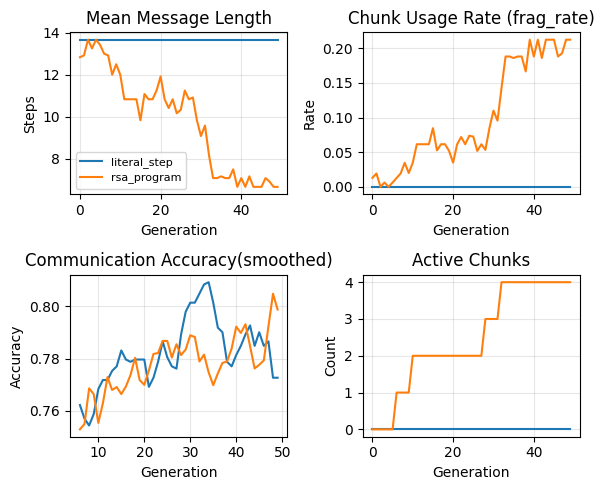

In [60]:
if SHOW_PLOTS:
    fig, axes = plt.subplots(2, 2, figsize=(6, 5))

    for mode in COMM_SPEAKER_MODES:
        sub = comm_df[comm_df["model"] == mode]
        axes[0,0].plot(sub["generation"], sub["msg_len"], label=mode)
        axes[0,1].plot(sub["generation"], sub["frag_rate"], label=mode)
        axes[1,0].plot(sub["generation"], sub["acc_comm"].rolling(window=7).mean(), label=mode)
        axes[1,1].plot(sub["generation"], sub["num_active_chunks"], label=mode)

    axes[0,0].set_xlabel("Generation")
    axes[0,0].set_ylabel("Steps")
    axes[0,0].set_title("Mean Message Length")
    axes[0,0].legend(fontsize=8)
    axes[0,0].grid(alpha=0.3)

    axes[0,1].set_xlabel("Generation")
    axes[0,1].set_ylabel("Rate")
    axes[0,1].set_title("Chunk Usage Rate (frag_rate)")
    axes[0,1].grid(alpha=0.3)

    axes[1,0].set_xlabel("Generation")
    axes[1,0].set_ylabel("Accuracy")
    axes[1,0].set_title("Communication Accuracy(smoothed)")
    axes[1,0].grid(alpha=0.3)

    axes[1,1].set_xlabel("Generation")
    axes[1,1].set_ylabel("Count")
    axes[1,1].set_title("Active Chunks")
    axes[1,1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


### Beta scan

In [46]:
# Beta scan (only affects rsa_program)
BETA_SCAN = [0.15, 0.3, 0.45]  # low, mid, high

In [47]:
def run_beta_scan(base_args):
    jobs = []
    for beta in BETA_SCAN:
        job = dict(base_args)
        job["speaker_mode"] = "rsa_program"
        job["speaker_beta_cost"] = float(beta)
        job["model_label"] = f"rsa_program_beta_{int(round(100 * float(beta)))}"
        jobs.append(job)

    if USE_PARALLEL:
        with ProcessPoolExecutor(max_workers=min(4, len(jobs))) as pool:
            results = list(pool.map(_run_comm_worker, jobs))
    else:
        results = [_run_comm_worker(j) for j in jobs]

    out = pd.concat(results, ignore_index=True)
    out.to_csv(os.path.join(OUT_DIR, "comm_by_gen_beta_scan.csv"), index=False)
    return out


In [48]:
beta_df = run_beta_scan(base_args)

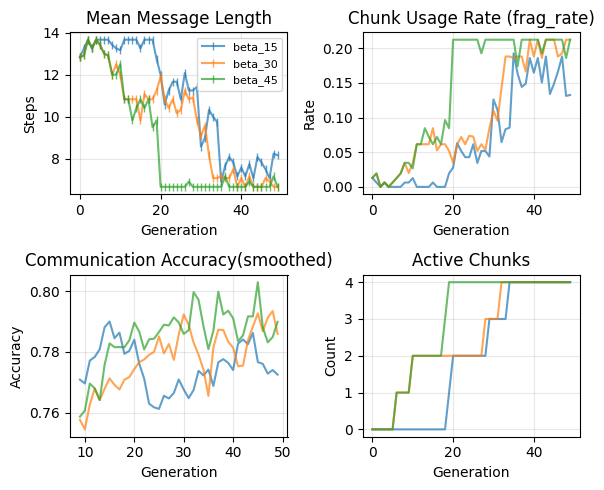

In [65]:

# Beta scan
if SHOW_PLOTS:
    fig, axes = plt.subplots(2, 2, figsize=(6, 5))

    for beta in BETA_SCAN:
        label = f"beta_{int(round(100 * float(beta)))}"
        model_label = f"rsa_program_beta_{int(round(100 * float(beta)))}"
        sub = beta_df[beta_df["model"] == model_label]
        axes[0, 0].plot(sub["generation"], sub["msg_len"], label=label, alpha=0.7, marker="|")
        axes[0, 1].plot(sub["generation"], sub["frag_rate"], label=label, alpha=0.7)
        axes[1, 0].plot(sub["generation"], sub["acc_comm"].rolling(window=10).mean(), label=label, alpha=0.7)
        axes[1, 1].plot(sub["generation"], sub["num_active_chunks"], label=label, alpha=0.7)

    axes[0,0].set_xlabel("Generation")
    axes[0,0].set_ylabel("Steps")
    axes[0,0].set_title("Mean Message Length")
    axes[0,0].legend(fontsize=8)
    axes[0,0].grid(alpha=0.3)

    axes[0,1].set_xlabel("Generation")
    axes[0,1].set_ylabel("Rate")
    axes[0,1].set_title("Chunk Usage Rate (frag_rate)")
    axes[0,1].grid(alpha=0.3)

    axes[1,0].set_xlabel("Generation")
    axes[1,0].set_ylabel("Accuracy")
    axes[1,0].set_title("Communication Accuracy(smoothed)")
    axes[1,0].grid(alpha=0.3)

    axes[1,1].set_xlabel("Generation")
    axes[1,1].set_ylabel("Count")
    axes[1,1].set_title("Active Chunks")
    axes[1,1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


## Ablation of gate

In [67]:
COMM_NUM_GENERATIONS = 70

base_args = {
        "ppt_id": COMM_PPT_ID,
        "data_model_dir": os.path.join(ROOT_DIR, "data", "model"),
        "num_generations": COMM_NUM_GENERATIONS,
        "lexemes": COMM_LEXEMES,
        "min_attempts": COMM_MIN_ATTEMPTS,
        "min_success_rate": COMM_MIN_SUCCESS_RATE,
        "p_innovate": COMM_P_INNOVATE,
        "pre_promote_chunk_correct": COMM_PRE_PROMOTE_CHUNK_CORRECT,
        "max_promote_per_gen": COMM_MAX_PROMOTE_PER_GEN,
        "speaker_alpha_prog": COMM_SPEAKER_ALPHA_PROG,
        "speaker_alpha_utt": COMM_SPEAKER_ALPHA_UTT,
        "speaker_beta_cost": COMM_SPEAKER_BETA_COST,
        "epsilon": COMM_EPSILON,
        "random_seed": SEED,
        "source_subdir": COMM_SOURCE_SUBDIR,
    }

In [68]:
control_df = run_control(base_args)


Running gated vs no-gate control...


In [ ]:
control_df.head()

,generation,acc_comm,msg_len,frag_rate,ppt_id,speaker_mode,num_active_chunks,max_candidate_attempts,max_candidate_success_rate,model,variant
0,0.0,0.773913,9.583333,0.086957,1.0,rsa_program,3.0,5.0,0.0,rsa_program,no_gate
1,1.0,0.731959,8.083333,0.134021,1.0,rsa_program,4.0,5.0,0.0,rsa_program,no_gate
2,2.0,0.769231,7.583333,0.164835,1.0,rsa_program,4.0,5.0,0.0,rsa_program,no_gate
3,3.0,0.802198,7.583333,0.153846,1.0,rsa_program,4.0,5.0,0.0,rsa_program,no_gate
4,4.0,0.775000,6.666667,0.212500,1.0,rsa_program,4.0,5.0,0.0,rsa_program,no_gate


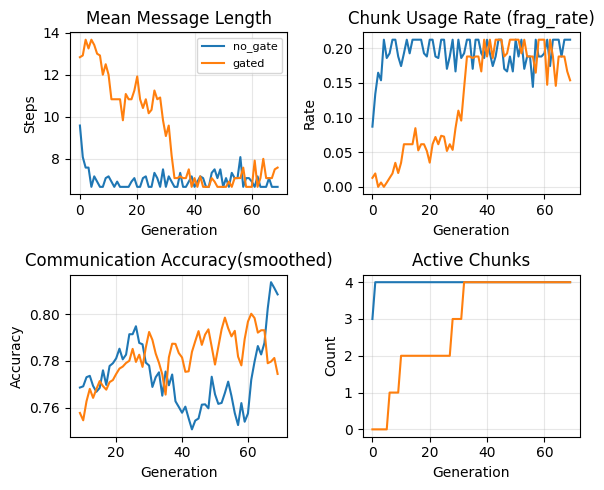

In [70]:

# Beta scan
if SHOW_PLOTS:
    fig, axes = plt.subplots(2, 2, figsize=(6, 5))

    for variant in ["no_gate", "gated"]:
        sub = control_df[control_df["variant"] == variant]
        axes[0,0].plot(sub["generation"], sub["msg_len"], label=variant)
        axes[0,1].plot(sub["generation"], sub["frag_rate"], label=variant)
        axes[1,0].plot(sub["generation"], sub["acc_comm"].rolling(window=10).mean(), label=variant)
        axes[1,1].plot(sub["generation"], sub["num_active_chunks"], label=variant)

    axes[0,0].set_xlabel("Generation")
    axes[0,0].set_ylabel("Steps")
    axes[0,0].set_title("Mean Message Length")
    axes[0,0].legend(fontsize=8)
    axes[0,0].grid(alpha=0.3)

    axes[0,1].set_xlabel("Generation")
    axes[0,1].set_ylabel("Rate")
    axes[0,1].set_title("Chunk Usage Rate (frag_rate)")
    axes[0,1].grid(alpha=0.3)

    axes[1,0].set_xlabel("Generation")
    axes[1,0].set_ylabel("Accuracy")
    axes[1,0].set_title("Communication Accuracy(smoothed)")
    axes[1,0].grid(alpha=0.3)

    axes[1,1].set_xlabel("Generation")
    axes[1,1].set_ylabel("Count")
    axes[1,1].set_title("Active Chunks")
    axes[1,1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


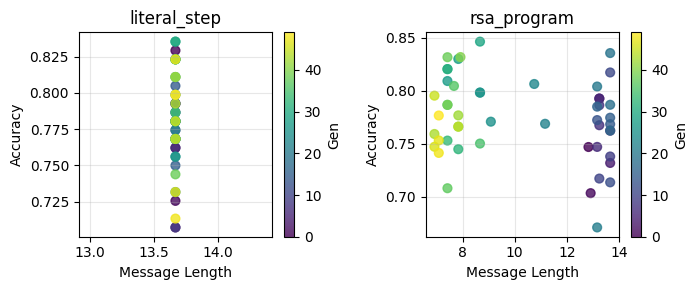

In [ ]:
if SHOW_PLOTS:
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    axes = axes.flatten()

    for i, mode in enumerate(COMM_SPEAKER_MODES):
        ax = axes[i]
        sub = comm_df[comm_df["model"] == mode]
        scatter = ax.scatter(sub["msg_len"], sub["acc_comm"],
                                c=sub["generation"], cmap="viridis", s=40, alpha=0.8)
        # ax.plot(list(sub["msg_len"]), list(sub["acc_comm"]), linewidth=1, alpha=0.5)
        ax.set_xlabel("Message Length")
        ax.set_ylabel("Accuracy")
        ax.set_title(mode)
        ax.grid(alpha=0.3)
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label("Gen")

    plt.tight_layout()
    plt.show()
